In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\nkosi\AppData\Local\Temp\ipykernel_9596\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Solves the Euler equations in iso-energetic form in generalised ξ−η coordinates to provide automatic shock-capturing.
## by NN Ndlovu

In [2]:
import numpy as np
from copy import deepcopy
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.colors as mclr
import gc, copy, time

#%matplotlib notebook
%matplotlib inline

## Functions

In [3]:
#------------------VINOKUR STRETCHING-------------------------------
# This is the python version of the popular stretching method.
def vinokur(lmax, smax, ds1e, ds2e):
    ''' 
        Stretches points on a surface so that a specified spacing
        at the boundaries is satisfied. Taken from NASA CR 3313 by 
        Vinokur (1980).

        In this version, 4 distinct iterations are made to better
        match the resulting delta-s values to the requested values.
        The four iterations are summarized below:

        1.  delta-s is set equal to the desired value.
        2.  delta-s from the last iteration is corrected from a Taylor
            series expansion.
        3.  delta-s is calculated from a linear fit between the first two
            guesses.
        4.  delta-s is calculated from a quadratic fit between the first
            three guesses, if indeed a quadratic will pass through the 
            desired value.  If it doesn't, it takes the value calculated 
            after three swipes.

        Additionally, this version uses the approximate inverse solution
        for y=sin(x)/x and y=sinh(x)/x rather than a Newton iteration.  The
        approximate solution was also taken from NASA CR 3313.

        This version of Vinokur was translated from Fortran coding.
        Use at own risk.
        Translated by P.Gauche 1994
    '''
    S = np.zeros(lmax)
    d1, d2 = np.zeros((5,3)), np.zeros((5,3))
    
    # ------------------------------------------------------------------------
    
    lmaxFloat = lmax;
    dsavg = smax/(lmaxFloat-1)
    #21    dsavg = 0.001        //DOES THIS EXECUTE AFTER PREV STEP?
    if ((ds1e >= smax) or (ds1e < 0.0)):
        dsavg = 0.001
    #22    dsavg=0.01
    if ((ds2e >= (smax-ds1e)) or (ds2e < 0.0)):
        dsavg = 0.001

    if ((ds1e == 0.0) and (ds2e == 0.0)):
        kase = 0
        ds1e = dsavg
        ds2e = dsavg
        nlast = 4

    elif (ds1e == 0.0):
        kase = 1
        nlast = 1

    #  23      continue
    #         if(slop.lt.0.0.or.slop.gt.1.0)go to 23
    #         ds1e=-slop

    elif (ds2e == 0.0):
        kase = 2
        nlast = 1

    #  24      continue
    #         if(slop.lt.0.0.or.slop.gt.1.0)go to 24
    #         ds2e=-slop

    else:
        kase = 0
        nlast = 4
    
    dss1 = 0.0
    dss2 = 0.0
    disc = 1
    disc1 = 1
    ds1 = 1
    ds2 = 1

    for n in range(1, nlast+1):
        if ((disc >= 0) and (disc1 > 0) and (ds1 >= 0) and (ds2 >= 0)):

            if (n <= 2):
                ds1 = ds1e - 0.5*dss1
                ds2 = ds2e + 0.5*dss2
                d1[n][1] = ds1
                d2[n][1] = ds2

            elif (n == 3):
                ds1 = -d1[1][2]*(d1[2][1]-d1[1][1])/(d1[2][2]-d1[1][2])+d1[1][1]
                ds2 = -d2[1][2]*(d2[2][1]-d2[1][1])/(d2[2][2]-d2[1][2])+d2[1][1]

                if (ds1 < 0.0):
                    if (d1[1][1] < d1[2][1]):
                        ds1 = 0.5*d1[1][1]
                    else:
                        ds1 = 0.5*d1[2][1]

                if (ds2 < 0.0):
                    if (d2[1][1] < d2[2][1]):
                        ds2 = 0.5*d2[1][1]
                    else:
                        ds2 = 0.5*d2[2][1]
                d1[n][1] = ds1
                d2[n][1] = ds2

            elif (n == 4):
                denom = -(d1[1][1]-d1[2][1])*(d1[2][1]-d1[3][1])*(d1[3][1]-d1[1][1])
                a11 = d1[2][1]-d1[3][1]
                a21 = (d1[3][1]**2)-(d1[2][1]**2)
                a31 = d1[2][1]*d1[3][1]*(d1[2][1]-d1[3][1])
                a12 = d1[3][1]-d1[1][1]
                a22 = (d1[1][1]**2)-(d1[3][1]**2)
                a32 = d1[3][1]*d1[1][1]*(d1[3][1]-d1[1][1])
                a13 = d1[1][1]-d1[2][1]
                a23 = (d1[2][1]**2)-(d1[1][1]**2);
                a33 = d1[1][1]*d1[2][1]*(d1[1][1]-d1[2][1]);
                b1 = (a11*d1[1][2]+a12*d1[2][2]+a13*d1[3][2])/denom;
                b2 = (a21*d1[1][2]+a22*d1[2][2]+a23*d1[3][2])/denom;
                b3 = (a31*d1[1][2]+a32*d1[2][2]+a33*d1[3][2])/denom;
                disc = (b2*b2-4*b1*b3)

                if (disc >= 0.0):
                    dd1 = (-b2+np.sqrt(disc))/(2*b1)
                    dd2 = (-b2-np.sqrt(disc))/(2*b1)
                    dd3 = d1[3][1]

                    if (abs(dd1-dd3) < abs(dd2-dd3)):
                        ds1 = dd1
                    else:
                        ds1 = dd2

                    denom = -(d2[1][1]-d2[2][1])*(d2[2][1]-d2[3][1])*(d2[3][1]-d2[1][1])
                    a11 = d2[2][1]-d2[3][1]
                    a21 = (d2[3][1]**2)-(d2[2][1]**2)
                    a31 = d2[2][1]*d2[3][1]*(d2[2][1]-d2[3][1])
                    a12 = d2[3][1]-d2[1][1]
                    a22 = (d2[1][1]**2)-(d2[3][1]**2)
                    a32 = d2[3][1]*d2[1][1]*(d2[3][1]-d2[1][1])
                    a13 = d2[1][1]-d2[2][1]
                    a23 = (d2[2][1]**2)-(d2[1][1]**2)
                    a33 = d2[1][1]*d2[2][1]*(d2[1][1]-d2[2][1])
                    b1 = (a11*d2[1][2]+a12*d2[2][2]+a13*d2[3][2])/denom
                    b2 = (a21*d2[1][2]+a22*d2[2][2]+a23*d2[3][2])/denom
                    b3 = (a31*d2[1][2]+a32*d2[2][2]+a33*d2[3][2])/denom
                    disc1 = (b2*b2-4*b1*b3)

                    if (disc1 > 0.0):
                        disc = disc1
                        dd1 = (-b2+np.sqrt(disc))/(2*b1)
                        dd2 = (-b2-np.sqrt(disc))/(2*b1)
                        dd3 = d2[3][1]

                        if (abs(dd1-dd3) < abs(dd2-dd3)):
                            ds2 =dd1
                        else:
                            ds2 = dd2

        # calculate constants
        if ((disc >= 0) and (disc1 > 0) and (ds1 >= 0) and (ds2 >= 0)):
            s0 = smax/(lmaxFloat-1)/ds1
            s1 = smax/(lmaxFloat-1)/ds2
            b = np.sqrt(s0*s1)
            a = np.sqrt(s0/s1)

            if (kase == 1):
                b = s1
            elif kase == 2:
                b = s0

        # calculate x based on value of B
        # if x is real     
        if ((b-1) < 0):    
            if (b < 0.26938972):
                x = np.pi*(1-b+(b**2)-(1+(np.pi**2)/6)*(b**3)+6.794732*(b**4)-13.205501*(b**5)+11.726095*(b**6))
            else:
                c = 1-b
                x = np.sqrt(6*c)*(1+0.15*c + 0.057321429*(c**2)+0.048774238*(c**3)-0.053337753*(c**4)+0.075845134*(c**5))

        # if x is zero
        if ((b-1) == 0):
            x = 0

        # if x is imaginary
        if ((b-1) > 0):
            if (b < 2.7829681):
                c = b-1
                x = np.sqrt(6*c)*(1-0.15*c+0.057321429*(c**2)-0.024907295*(c**3)+0.0077424461*(c**4)-0.0010794123*(c**5))
            else:
                v = np.log(b)
                w = 1/b - 0.028527431
                x = v+(1+1/v)*np.log(2*v)-0.02041793+0.24902722*w+1.9496443*(w**2)-2.6294547*(w**3)+8.56795911*(w**4)

        # distribute points along boundary
        if ((kase == 1) or (kase ==2)):
            S[0] = 0
            S[lmax-1] = smax

            for i in range(2, lmax):
                iFloat = i
                j = lmax+1-i
                xi = (iFloat-1)/(lmaxFloat-1)

                if (b > 1.0001):
                    u1 = 1 + np.tanh(x/2*(xi-1))/np.tanh(x/2)
                elif (b < 0.9999):
                    u1 = 1 + np.tan(x/2*(xi-1))/np.tan(x/2)
                else:
                    u1 = xi*(1-0.5*(b-1)*(1-xi)*(2-xi))

                u2 = sinh(xi*x)/sinh(x);
                if (kase == 1):
                    fact = abs(ds1e)
                    S[j-1] = ((1-fact)*(1-u1) + fact*(1-u2))*smax
                elif (kase == 2):
                    fact = fabs(ds2e)
                    S[i-1] = ((1-fact)*u1+fact*u2)*smax
        else:
            for i in range(1, lmax+1):
                iFloat = i
                xi = (iFloat-1)/(lmaxFloat-1)
                cnum = x*(xi-0.5)
                cden = x/2

                if (b < 0.9999):
                    cc = np.tan(cnum)/np.tan(cden)
                    u = 0.5*(1+cc)
                elif ((b >= 0.9999) and (b <= 1.0001)):
                    u = xi*(1+2*(b-1)*(xi-0.5)*(1-xi))
                elif (b > 1.0001):
                    cc = np.tanh(cnum)/np.tanh(cden)
                    u = 0.5*(1+cc)
                S[i-1] = u*smax/(a+(1-a)*u)
        
        if (lmax >= 4):
            dss1 = (-S[4-1]+4*S[3-1]-5*S[2-1]+2*S[1-1])
            dss2 = (2*S[lmax-1]-5*S[lmax-2]+4*S[lmax-3]-S[lmax-4])/2

        es1 = S[2-1]-S[1-1]
        es2 = S[lmax-1]-S[lmax-2]

        if (n != 4):
            d1[n][2] = es1-ds1e
            d2[n][2] = es2-ds2e

    return S

In [4]:
def mkln(p1, p2, N):
    smax = np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
    s = np.linspace(0, smax, N)
    alp = np.arctan2(p2[1]-p1[1], p2[0]-p1[0])
    pi = np.pi
    x = np.cos(alp)*s
    y = np.cos(np.pi/2 - alp)*s
    return np.array([p1[0]+x, p1[1]+y])    

def streln(p1, p2, N, ds1e, ds2e):
    smax = np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
    s = vinokur(N, smax, ds1e, ds2e)
    alp = np.arctan2(p2[1]-p1[1], p2[0]-p1[0])
    pi = np.pi
    x = np.cos(alp)*s
    y = np.cos(np.pi/2 - alp)*s
    return np.array([p1[0]+x, p1[1]+y])

def mkUpperBoundary(p1, le, te, p2, Np, Nd, Na):
    # p1 - [x,y] @ node 1, le - [x,0] @ para start, te - [x,0] @ para end, p2 - [x,y] @ node 2
    # generate x, y points along upstream lower boundary
    upstreampoints = mkln(p1, [le,p1[1]], Np)
    upstreampointsx = np.delete(upstreampoints[0], -1); upstreampointsy = np.delete(upstreampoints[1], -1) # Remove LE start point - dup
    upstreampoints = np.array([upstreampointsx, upstreampointsy])
    # generate x, y points along para
    x = np.linspace(le, te, Na)
    y = np.ones(len(x))*p1[1]
    airfoilpoints = np.array([x, y])
    # generate x, y points along downstream upper boundary
    downstreampoints = mkln([te,p1[1]], p2, Nd)
    downstreampointsx = np.delete(downstreampoints[0], 0); downstreampointsy = np.delete(downstreampoints[1], 0) # Remove LE start point - dup
    downstreampoints = np.array([downstreampointsx, downstreampointsy])
    return np.array([np.concatenate((upstreampoints[0], airfoilpoints[0], downstreampoints[0])), np.concatenate((upstreampoints[1], airfoilpoints[1], downstreampoints[1]))])

def mkLowerBoundary(p1, le, te, p2, t, Np, Nd, Na, stretching, SIe, SLe, STe, SEe):
    # p1 - [x,y] @ node 1, le - [x,0] @ para start, te - [x,0] @ para end, p2 - [x,y] @ node 2
    # generate x, y points along upstream lower boundary
    if(stretching==False):
        upstreampoints = mkln(p1, [le,0], Np)
        x = np.linspace(le, te, Na)
        downstreampoints = mkln([te,0], p2, Nd)
    else:
        upstreampoints = streln(p1, [le,0], Np, SIe, SLe)
        x = streln([le,0], [te,0], Na, SLe, STe)[0] # [0] get only x points
        downstreampoints = streln([te,0], p2, Nd, STe, SEe)
        
    upstreampointsx = np.delete(upstreampoints[0], -1); upstreampointsy = np.delete(upstreampoints[1], -1) # Remove LE start point - dup
    upstreampoints = np.array([upstreampointsx, upstreampointsy])
    # generate x, y points along para
    #x = np.linspace(le, te, Na)
    y = 2*t*x*(1-x)
    airfoilpoints = np.array([x, y])
    # generate x, y points along downstream lower boundary
    #downstreampoints = mkln([te,0], p2, Nd)
    downstreampointsx = np.delete(downstreampoints[0], 0); downstreampointsy = np.delete(downstreampoints[1], 0) # Remove LE start point - dup
    downstreampoints = np.array([downstreampointsx, downstreampointsy])
    return np.array([np.concatenate((upstreampoints[0], airfoilpoints[0], downstreampoints[0])), np.concatenate((upstreampoints[1], airfoilpoints[1], downstreampoints[1]))])

def TFI(face1_points, face2_points, face3_points, face4_points):
    NI, NJ = len(face1_points[0]), len(face2_points[1])
    x, y = np.zeros((NJ, NI)), np.zeros((NJ, NI))
    x[0,:], x[-1,:] = face1_points[0], face3_points[0]
    y[0,:], y[-1,:] = face1_points[1], face3_points[1]
    x[:,0], x[:,-1] = face2_points[0], face4_points[0]
    y[:,0], y[:,-1] = face2_points[1], face4_points[1]

    x1, y1 = np.zeros((NJ, NI)), np.zeros((NJ, NI))
    x2, y2 = np.zeros((NJ, NI)), np.zeros((NJ, NI))

    for j in range(0, NJ):
        for i in range(0, NI):
            phi0 = float(i)/float(NI-1)
            phi1 = float(NI-1-i)/float(NI-1)
            x1[j, i] = phi0*x[j,NI-1] + phi1*x[j,0]
            y1[j, i] = phi0*y[j,NI-1] + phi1*y[j,0]

    for j in range(0, NJ):
        for i in range(0, NI):
            psi0 = float(j)/float(NJ-1)
            psi1 = float(NJ-1-j)/float(NJ-1)
            x2[j, i] = psi0*(x[NJ-1,i] - x1[NJ-1,i]) + psi1*(x[0,i] - x1[0,i])
            y2[j, i] = psi0*(y[NJ-1,i] - y1[NJ-1,i]) + psi1*(y[0,i] - y1[0,i])

    for j in range(0, NJ):
        for i in range(0, NI):
            x[j, i] = x1[j,i] + x2[j,i]
            y[j, i] = y1[j,i] + y2[j,i]
    cells = (len(x)-1)*(len(y)-1)
    return np.array([x,y, cells])

In [5]:
def Project_Points(input_block, BC_face):
    block = deepcopy(input_block)

    # Flip the arrays for 3 and 4
    # Get face coordinates
    if BC_face == 1 or BC_face == 3:
        if BC_face == 3:
            blockx = np.flip(block[0], axis=1) # Flip horizontally (axis=1)
            xface, yface = block[0][0,:], block[1][0,:]
        else:
            xface, yface = block[0][0,:], block[1][0,:]
    elif BC_face == 2 or BC_face == 4:
        if BC_face == 4:
            block[0], block[1] = np.flip(block[0], axis=0), np.flip(block[1], axis=0) # Flip vertically (axis=0)
            xface, yface = block[0][0,:], block[1][0,:]        
        else:
            xface, yface = block[0][:,0], block[1][0,:]
    # elif BC_face == 3:
    #     xface, yface = block[0][-1,:], block[1][-1,:]
    else:
        raise ValueError('Not 1, 2, 3 or 4!')
    #     xface, yface = block[0][:,-1], block[1][:,-1]
    blockShape = (len(block[0][:,0]), len(block[0][0,:]))
    #px, py = np.zeros((len(yface),len(xface))), np.zeros((len(yface),len(xface)))
    px, py = np.zeros(blockShape), np.zeros(blockShape)
    a = np.deg2rad(90)

    if BC_face == 2 or BC_face == 4:
        for i in range(1, len(yface)-1): # along BC face axis
            S0 = np.array([xface[i], yface[i]]) # BC face points
            u = np.array([xface[i+1]-xface[i-1], yface[i+1]-yface[i-1]]) # Form slope vector
            unitV = u/np.linalg.norm(u) 
            R = np.array([[np.cos(a), np.cos((np.pi/2)+a)], [np.cos((np.pi/2)-a), np.cos(a)]]) 
            unitV_Prime = np.dot(R, unitV) # Rotate slope vector through 90 deg to normal

            P = np.array([[unitV_Prime[0]**2, unitV_Prime[0]*unitV_Prime[1]], [unitV_Prime[0]*unitV_Prime[1], unitV_Prime[1]**2]])
            S = np.array([block[0][i,:]-S0[0], block[1][i,:]-S0[1]]) # Arclength segments along line i
            p = np.dot(P, S)
            px[i,0], py[i,0] = S0[0], S0[1]
            px[i,:], py[i,:] = px[i,0] + p[0], py[i,0] + p[1]

    if BC_face == 1 or BC_face == 3:
        for i in range(1, len(xface)-1): # along BC face axis
            S0 = np.array([xface[i], yface[i]]) # BC face points
            u = np.array([xface[i+1]-xface[i-1], yface[i+1]-yface[i-1]]) # Form slope vector
            unitV = u/np.linalg.norm(u) 
            R = np.array([[np.cos(a), np.cos((np.pi/2)+a)], [np.cos((np.pi/2)-a), np.cos(a)]]) 
            unitV_Prime = np.dot(R, unitV) # Rotate slope vector through 90 deg to normal

            P = np.array([[unitV_Prime[0]**2, unitV_Prime[0]*unitV_Prime[1]], [unitV_Prime[0]*unitV_Prime[1], unitV_Prime[1]**2]])
            S = np.array([block[0][:,i]-S0[0], block[1][:,i]-S0[1]]) # Arclength segments along line i
            p = np.dot(P, S)
            px[0,i], py[0,i] = S0[0], S0[1]
            px[:,i], py[:,i] = px[0,i] + p[0], py[0,i] + p[1]

    block[0][1:-1,1:-1], block[1][1:-1,1:-1] = px[1:-1,1:-1], py[1:-1,1:-1]
    return block

def Blend(oblock, pblock, Lt, p, BC_face):
    ''' l - index on line length
        Lt - Transition index
        p - power '''
    fill = np.arange(0,len(oblock[0][0]))
    l = np.full((len(oblock[0][:,0]), len(oblock[0][0])), fill)
    if BC_face == 1 or BC_face == 3:
        fill = np.arange(0,len(oblock[0][:,0]))
        l = np.full((len(oblock[0][0]), len(oblock[0][:,0])), fill).T
    #print(l)
    f1, f2 = (2/np.pi)*np.arctan(np.power((l/Lt),p)), (2/np.pi)*np.arctan(np.power((l/Lt),-p))
    #print(f1)
    #print(f2)
    bl_block = np.array([oblock[0]*f1 + pblock[0]*f2, oblock[1]*f1 + pblock[1]*f2, oblock[2]])
    return bl_block

def BlendingFunc(input_block, BC_face, Lt, p):
    pblock = Project_Points(input_block, BC_face)
    blockk = Blend(input_block, pblock, Lt, p, BC_face)
    return blockk

## Calculation Starts Here

In [6]:
# -------------------- Define nodal point of each block --------------------------------
p1 = [-2.0, 0.0]
p2 = [3.0, 0.0]
p3 = [-2.0, 2.0]
p4 = [3.0, 2.0]
t = 0.12

Np, Na, Nd = 100, 100, 100 
Ny = 200

stretching = False
SIe, SLe, STe, SEe = 0.1, 0.01, 0.01, 0.1
Sf2b, Sf2t = 0.01, 0.1
Sf4b, Sf4t = 0.01, 0.1

face1_points = mkLowerBoundary(p1, 0, 1, p2, t, Np, Nd, Na, stretching, SIe, SLe, STe, SEe)
#face2_points = streln(p1, p3, Ny, Sf2b, Sf2t)
face2_points = mkln(p1, p3, Ny)
face3_points = mkUpperBoundary(p3, -0.5, 1.5, p4, Np, Nd,Na)
#face4_points = streln(p2, p4, Ny, Sf4b, Sf4t)
face4_points = mkln(p2, p4, Ny)

# ------------------------- Make blocks here -------------------------------------
#face1_points = streln(p31, p3, Nx, 0.1, 0.1)
#face2_points = streln(p31, p1, Ny, 0.1, 0.5)
#face3_points = streln(p1, p2, Nx, 0.1, 0.1)
#face4_points = streln(p3, p2, Ny, 0.1, 0.5)
block1 = TFI(face1_points, face2_points, face3_points, face4_points)
#block1 = BlendingFunc(block1, 1, 2, 10)
#len(face1_points[0]), len(face1_points[1]), len(face3_points[0]), len(face3_points[1])

C:\Users\nkosi\AppData\Local\Temp\ipykernel_9596\1695523850.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([x,y, cells])


C:\Users\nkosi\AppData\Local\Temp\ipykernel_9596\1547712185.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(block1[0], block1[1], np.zeros_like(block1[0]), edgecolors='b', cmap=myCmap)


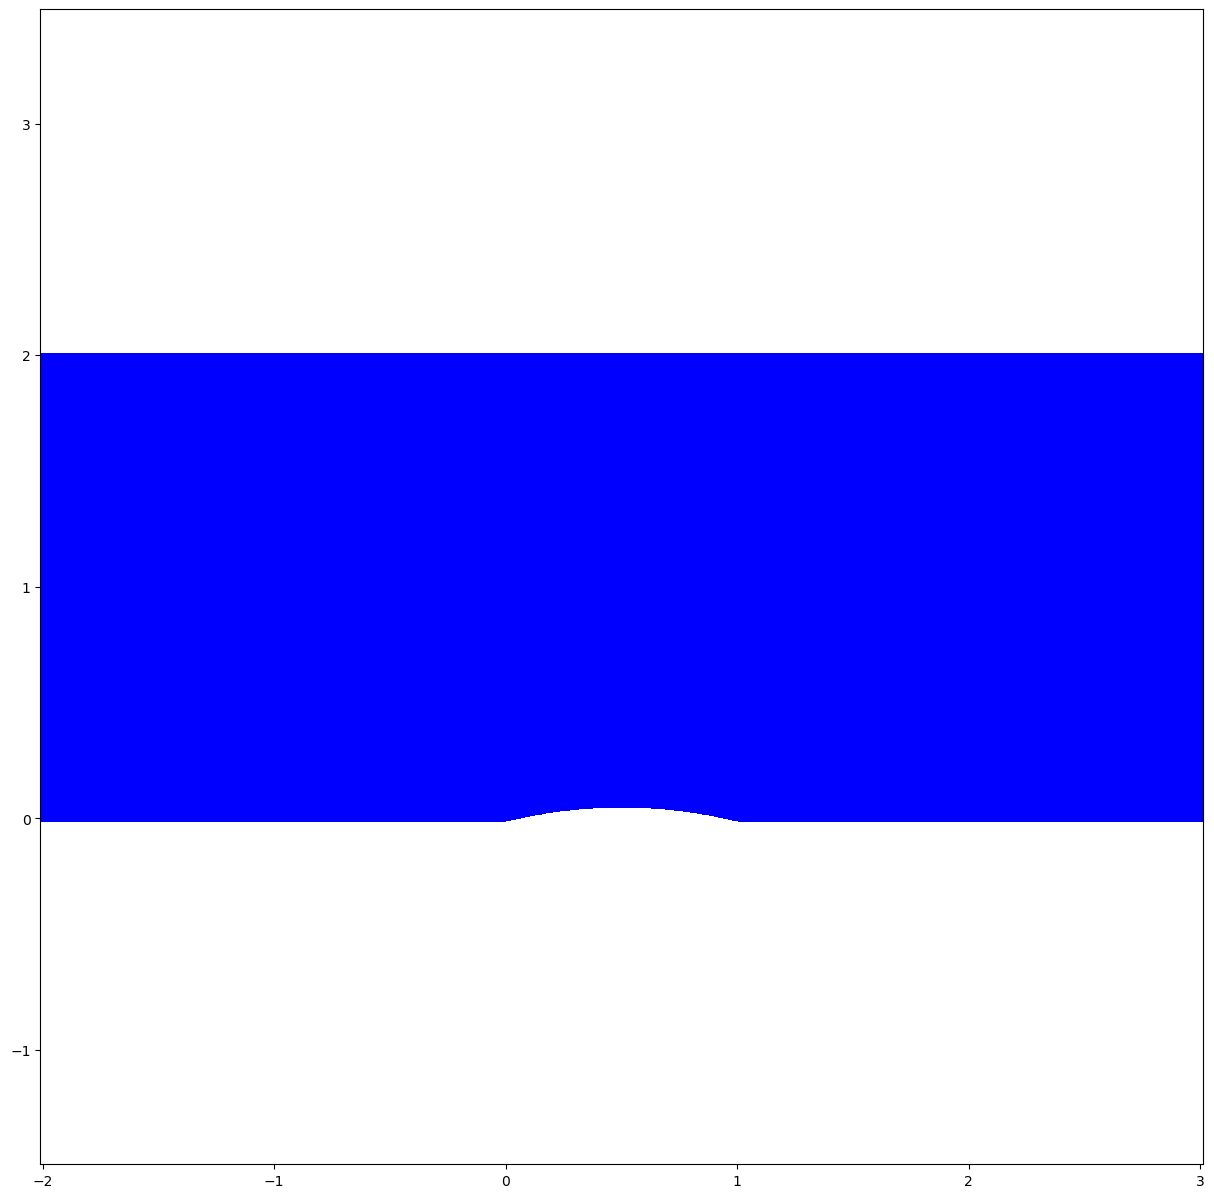

Cells: 39601


In [7]:
plt.figure(figsize=(15,15))

myCmap = mclr.ListedColormap(['white','white'])
#plt.scatter(face1_points[0], face1_points[1])
#plt.scatter(face2_points[0], face2_points[1])
#plt.scatter(face3_points[0], face3_points[1])
#plt.scatter(face4_points[0], face4_points[1])
plt.pcolormesh(block1[0], block1[1], np.zeros_like(block1[0]), edgecolors='b', cmap=myCmap)
plt.axis('equal')
#plt.xlim([-0.25,0.25])
#plt.ylim([0.0,0.5])
plt.show()

Cells = block1[2]
print(f'Cells: {Cells}')

In [8]:
xpoints, ypoints = block1[0], block1[1]
#xpoints, ypoints

In [9]:
dx, dy = np.gradient(xpoints, edge_order=2), np.gradient(ypoints, edge_order=2)
xe, xn, ye, yn = dx[1], dx[0], dy[1], dy[0]

J = 1/(xe*yn - xn*ye)
J_inverse = xe*yn - xn*ye
ex, nx, ey, ny = J*yn, -J*ye, -J*xn, J*xe

A1 = ex**2 + ey**2; A3 = nx**2+ ny**2
CellAspectRatio_Sqr = A1/A3

A2 = ex*nx + ey*ny # Orthogonality

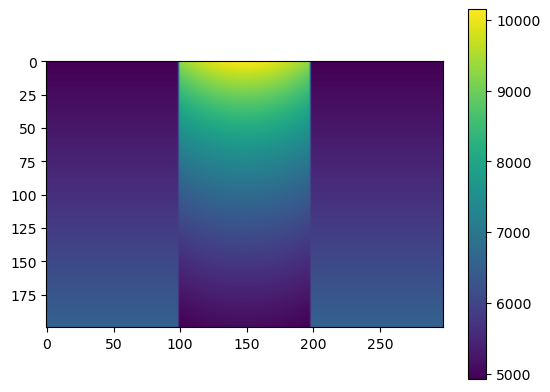

In [10]:

#plt.imshow(CellAspectRatio_Sqr)
#plt.imshow(A2)
plt.figure()
plt.imshow(J)
plt.colorbar()
plt.show()

In [11]:
# # v1
# Gamma = 1.4
# pinf = 1
# rho_inf = 1
# Minf = 2.5

# rho, rho_n1_bar, rho_n1 = np.ones((xe.shape)), np.ones((xe.shape)), np.ones((xe.shape)) # den_inf = 1.0
# u, u_n1_bar, u_n1 = np.ones((xe.shape)), np.ones((xe.shape)), np.ones((xe.shape))
# v, v_n1_bar, v_n1 = np.zeros((xe.shape)), np.zeros((xe.shape)), np.zeros((xe.shape))
# p, p_n1_bar, p_n1 = np.ones((xe.shape)), np.ones((xe.shape)), np.ones((xe.shape))

# Uc = u*ex + v*ey 
# Vc = u*nx + v*ny
# Uc_n1_bar, Vc_n1_bar = copy.deepcopy(Uc), copy.deepcopy(Vc)

# Vc[0,:] = 0 # BC - {Flow tangency} Vc on lower boundary
# p[0,:] = 2*p[1,:] - p[2,:] # lower boundary
# Uc[0,:] = 2*Uc[1,:] - Uc[2,:] # lower boundary

# Vc[-1,:] = 0 # BC {vinf} on upper boundary

# Vc[:,0] = 0 # BC {vinf} on inflow boundary



# i, j = 1, 1

# def ApplyBCs():
#     Vc[0,:] = 0 # BC - {Flow tangency} Vc on lower boundary
#     Uc[0,:] = 2*Uc[1,:] - Uc[2,:]; 
#     p[0,:] = 2*p[1,:] - p[2,:]; p_n1_bar[0,:] = 2*p_n1_bar[1,:] - p_n1_bar[2,:]; p_n1[0,:] = 2*p_n1[1,:] - p_n1[2,:]
#     v[0,:] = -Uc[0,:]*(nx[0,:]/J[0,:]); u[0,:] = -Uc[0,:]*(ny[0,:]/J[0,:])
    
    
#     Vc[-1,:] = 0 # BC {vinf} on upper boundary
    
#     Vc[:,0] = 0 # BC {vinf} on inflow boundary
#     print("Ran")

# dt = 0.02
# num_iterations = 2
# iterations = np.zeros(num_iterations)
# residuals = np.zeros(num_iterations)

# for t in range(0, len(iterations)):
#     ApplyBCs()
#     for i in range(1,xe.shape[1]-1):
#         for j in range(1,xe.shape[0]-1): 
#             # Predictor Step
#             U_j_i_t = J_inverse[j,i] * np.array([rho[j,i], rho[j,i]*u[j,i], rho[j,i]*v[j,i]])
#             F_j_i1_t = J_inverse[j,i+1] * np.array([rho[j,i+1]*Uc[j,i+1], 
#                                                     rho[j,i+1]*u[j,i+1]*Uc[j,i+1] + p[j,i+1]*ex[j,i+1], 
#                                                     rho[j,i+1]*v[j,i+1]*Uc[j,i+1] + p[j,i+1]*ey[j,i+1]])
#             F_j_i_t = J_inverse[j,i] * np.array([rho[j,i]*Uc[j,i], 
#                                                  rho[j,i]*u[j,i]*Uc[j,i] + p[j,i]*ex[j,i], 
#                                                  rho[j,i]*v[j,i]*Uc[j,i] + p[j,i]*ey[j,i]])
#             G_j1_i_t = J_inverse[j+1,i] * np.array([rho[j+1,i]*Vc[j+1,i], 
#                                                     rho[j+1,i]*u[j+1,i]*Vc[j+1,i] + p[j+1,i]*nx[j+1,i], 
#                                                     rho[j+1,i]*v[j+1,i]*Vc[j+1,i] + p[j+1,i]*ny[j+1,i]])
#             G_j_i_t = J_inverse[j,i] * np.array([rho[j,i]*Vc[j,i], 
#                                                  rho[j,i]*u[j,i]*Vc[j,i] + p[j,i]*nx[j,i], 
#                                                  rho[j,i]*v[j,i]*Vc[j,i] + p[j,i]*ny[j,i]])

#             # i. U_bar = U – delt(DelF + DelG)
#             U_j_i_t_n1_bar = U_j_i_t - dt*(F_j_i1_t-F_j_i_t + G_j1_i_t-G_j_i_t)  
#             # ii. convert from U to rho, u, v
#             rho_n1_bar[j,i] = U_j_i_t_n1_bar[0]/J_inverse[j,i]
#             u_n1_bar[j,i], v_n1_bar[j,i] = U_j_i_t_n1_bar[1]/(J_inverse[j,i]*rho_n1_bar[j,i]), U_j_i_t_n1_bar[2]/(J_inverse[j,i]*rho_n1_bar[j,i])
#             T = ( (1/((Gamma-1)*(Minf**2))) + 0.5 - (((u_n1_bar[j,i]**2) + (v_n1_bar[j,i]**2))/2.0))*(Gamma-1)*(Minf**2)
#             # iii. Calculate p from u,v,rho
#             p_n1_bar[j,i] = (rho_n1_bar[j,i]*T)/(Gamma*(Minf**2)) 
#             # iv. Calculate Uc, Vc
#             Uc_n1_bar[j,i], Vc_n1_bar[j,i] = u_n1_bar[j,i]*ex[j,i] + v_n1_bar[j,i]*ey[j,i], u_n1_bar[j,i]*nx[j,i] + v_n1_bar[j,i]*ny[j,i]  
#             # iv. F_bar,G_bar (f(metrics, rho,u,v,Uc,Vc))
#             F_j_i_t_n1_bar = J_inverse[j,i] * np.array([rho_n1_bar[j,i]*Uc_n1_bar[j,i], 
#                                                         rho_n1_bar[j,i]*u_n1_bar[j,i]*Uc_n1_bar[j,i] + p_n1_bar[j,i]*ex[j,i], 
#                                                         rho_n1_bar[j,i]*v_n1_bar[j,i]*Uc_n1_bar[j,i] + p_n1_bar[j,i]*ey[j,i]])
#             F_j_1i_t_n1_bar = J_inverse[j,i-1] * np.array([rho_n1_bar[j,i-1]*Uc_n1_bar[j,i-1], 
#                                                            rho_n1_bar[j,i-1]*u_n1_bar[j,i-1]*Uc_n1_bar[j,i-1] + p_n1_bar[j,i-1]*ex[j,i], 
#                                                            rho_n1_bar[j,i-1]*v_n1_bar[j,i-1]*Uc_n1_bar[j,i-1] + p_n1_bar[j,i-1]*ey[j,i-1]])
#             G_1j_i_t_n1_bar = J_inverse[j-1,i] * np.array([rho_n1_bar[j-1,i]*Vc_n1_bar[j-1,i], 
#                                                            rho_n1_bar[j-1,i]*u_n1_bar[j-1,i]*Vc_n1_bar[j-1,i] + p_n1_bar[j-1,i]*nx[j-1,i], 
#                                                            rho_n1_bar[j-1,i]*v_n1_bar[j-1,i]*Vc_n1_bar[j-1,i] + p_n1_bar[j-1,i]*ny[j-1,i]])
#             G_j_i_t_n1_bar = J_inverse[j,i] * np.array([rho_n1_bar[j,i]*Uc_n1_bar[j,i], 
#                                                         rho_n1_bar[j,i]*u_n1_bar[j,i]*Vc_n1_bar[j,i] + p_n1_bar[j,i]*nx[j,i], 
#                                                         rho_n1_bar[j,i]*v_n1_bar[j,i]*Vc_n1_bar[j,i] + p_n1_bar[j,i]*ny[j,i]])

#             # Corrector Step
#             U_j_i_t_n1 = 0.5*(U_j_i_t + U_j_i_t_n1_bar - dt*(F_j_i_t_n1_bar-F_j_1i_t_n1_bar + G_j_i_t_n1_bar-G_1j_i_t_n1_bar))
#             rho_n1[j,i] = U_j_i_t_n1[0]/J_inverse[j,i]
#             u_n1[j,i], v_n1[j,i] = U_j_i_t_n1[1]/(J_inverse[j,i]*rho_n1[j,i]), U_j_i_t_n1[2]/(J_inverse[j,i]*rho_n1[j,i]) # ii.
#             T = ( (1/((Gamma-1)*(Minf**2))) + 0.5 - (((u_n1[j,i]**2) + (v_n1[j,i]**2))/2.0))*(Gamma-1)*(Minf**2)
#             p_n1[j,i] = (rho_n1[j,i]*T)/(Gamma*(Minf**2)) 

#     delRho, delU, delV = abs(rho_n1-rho).max(), abs(u_n1-u).max(), abs(v_n1-v).max()
#     residuals[t] = max(delRho, delU, delV)

#     rho, u, v = copy.deepcopy(rho_n1), copy.deepcopy(u_n1), copy.deepcopy(v_n1)
#     Uc = u*ex + v*ey 
#     Vc = u*nx + v*ny
#     p = copy.deepcopy(p_n1)
#     Cp = (p_n1[0,:] - pinf) /(0.5*rho_inf*1)
    
#     gc.collect()


# u_n1_bar
# #Cp
# #rho_n1_bar
# #v_n1_bar
# #p_n1[0,:]
# #residuals
# p

In [12]:
def ApplyBCs(rho, u, v, Uc, Vc, p, T):
    u[:,0] = uinf; v[:,0] = vinf # BC {uinf; vinf} on inflow boundary
    rho[:,0] = rhoinf; p[:,0] = pinf; T[:,0] = Tinf # BC {rhoinf; pinf; Tinf} on inflow boundary
    
    u[-1,:] = uinf; v[-1,:] = vinf # BC {uinf; vinf} on upper boundary
    rho[-1,:] = rhoinf; p[-1,:] = pinf; T[-1,:] = Tinf # BC {rhoinf; pinf; Tinf} on upper boundary    
    
    Uc = u*ex + v*ey; Vc = u*nx + v*ny
    Vc[0,:] = 0 # BC - {Flow tangency} Vc on lower boundary
    Uc[0,:] = 2*Uc[1,:] - Uc[2,:]; 
    p[0,:] = 2*p[1,:] - p[2,:]
    v[0,:] = -Uc[0,:]*(nx[0,:]/J[0,:]); u[0,:] = Uc[0,:]*(ny[0,:]/J[0,:])
    T[0,:] = ( (1/((Gamma-1)*(Minf**2))) + 0.5 - (((u[0,:]**2) + (v[0,:]**2))/2.0))*(Gamma-1)*(Minf**2)
    rho[0,:] = p[0,:]*(Gamma*(Minf**2))/T[0,:]
    
    return rho, u, v, Uc, Vc, p, T

def Uji(j, i, rho, u, v):
    return J_inverse[j,i] * np.array([rho[j,i], rho[j,i]*u[j,i], rho[j,i]*v[j,i]])

def Fji(j, jp, i, ip, rho, u, v, Uc, Vc, p):
    return J_inverse[j+jp,i+ip] * np.array([rho[j+jp,i+ip]*Uc[j+jp,i+ip], 
                                            rho[j+jp,i+ip]*u[j+jp,i+ip]*Uc[j+jp,i+ip] + p[j+jp,i+ip]*ex[j+jp,i+ip], 
                                            rho[j+jp,i+ip]*v[j+jp,i+ip]*Uc[j+jp,i+ip] + p[j+jp,i+ip]*ey[j+jp,i+ip]])
                  
def Gji(j, jp, i, ip, rho, u, v, Uc, Vc, p):
    return J_inverse[j+jp,i+ip] * np.array([rho[j+jp,i+ip]*Vc[j+jp,i+ip], 
                                            rho[j+jp,i+ip]*u[j+jp,i+ip]*Vc[j+jp,i+ip] + p[j+jp,i+ip]*nx[j+jp,i+ip], 
                                            rho[j+jp,i+ip]*v[j+jp,i+ip]*Vc[j+jp,i+ip] + p[j+jp,i+ip]*ny[j+jp,i+ip]])

def dt(j, i, Uc, Vc):
    return dtref/(Uc[j,i]+Vc[j,i] + c*(ex[j,i]**2 + ey[j,i]**2 + nx[j,i]**2 + ny[j,i]**2)**0.5)

def Predictor_func(j, i, rho, u, v, Uc, Vc, p):
    Utn = Uji(j, i, rho, u, v)
    Ftn = Fji(j, 0, i, 0, rho, u, v, Uc, Vc, p)
    Ftn_ip1 = Fji(j, 0, i, 1, rho, u, v, Uc, Vc, p)
    Gtn = Gji(j, 0, i, 0, rho, u, v, Uc, Vc, p)
    Gtn_jp1 = Gji(j, 1, i, 0, rho, u, v, Uc, Vc, p)
    return Utn - dt(j, i, Uc, Vc)*(Ftn_ip1 - Ftn + Gtn_jp1 - Gtn)

def U_to_Vars(U, j, i, rho, u, v, Uc, Vc, p, T):
    # U to Predictor vars
    rho[j,i] = U[0]/J_inverse[j,i]
    u[j,i], v[j,i] = U[1]/(J_inverse[j,i]*rho[j,i]), U[2]/(J_inverse[j,i]*rho[j,i])
    T[j,i] = ( (1/((Gamma-1)*(Minf**2))) + 0.5 - (((u[j,i]**2) + (v[j,i]**2))/2.0))*(Gamma-1)*(Minf**2)
    p[j,i] = rho[j,i]*T[j,i]/(Gamma*(Minf**2))
    Uc[j,i] = u[j,i]*ex[j,i] + v[j,i]*ey[j,i]; Vc[j,i] = u[j,i]*nx[j,i] + v[j,i]*ny[j,i]
    return rho, u, v, Uc, Vc, p, T

def Run_Predictor_Corrector_Loop(rho, u, v, Uc, Vc, p, T):
    rho, u, v, Uc, Vc, p, T = ApplyBCs(rho, u, v, Uc, Vc, p, T)
    rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1, Tpn1 = copy.deepcopy(rho), copy.deepcopy(u), copy.deepcopy(v), copy.deepcopy(Uc), copy.deepcopy(Vc), copy.deepcopy(p), copy.deepcopy(T)
    

    # Predictor loop
    for j in range(0,xe.shape[0]-1):
        for i in range(0,xe.shape[1]-1): 
        #print(f'j: {j}')
        #for i in range(0,1):
            Utpn1 = Predictor_func(j, i, rho, u, v, Uc, Vc, p)
            #print(f'i: {i}')
            #print(f'Utn pred n+1: {Utpn1}')
            rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1, Tpn1 = U_to_Vars(Utpn1, j, i, rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1, Tpn1)
    
    rhon1, un1, vn1, Ucn1, Vcn1, pn1, Tn1 = copy.deepcopy(rhopn1), copy.deepcopy(upn1), copy.deepcopy(vpn1), copy.deepcopy(Ucpn1), copy.deepcopy(Vcpn1), copy.deepcopy(ppn1), copy.deepcopy(Tpn1)
    # Corrector loop
    for j in range(1,xe.shape[0]):
        for i in range(1,xe.shape[1]): 
            Utn = Uji(j, i, rho, u, v)
            Utpn1 = Uji(j, i, rhopn1, upn1, vpn1)
            # Predicted F & G vars
            Ftpn1 = Fji(j, 0, i, 0, rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1)
            Ftpn1_1ip = Fji(j, 0, i, -1, rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1)
            Gtpn1 = Gji(j, 0, i, 0, rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1)
            Gtpn1_1jp = Gji(j, -1, i, 0, rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1)
            
            Utn1 = 0.5*(Utn + Utpn1 - dt(j, i, Ucpn1, Vcpn1)*(Ftpn1-Ftpn1_1ip + Gtpn1-Gtpn1_1jp))
            rhon1, un1, vn1, Ucn1, Vcn1, pn1, Tn1 = U_to_Vars(Utn1, j, i, rhon1, un1, vn1, Ucn1, Vcn1, pn1, Tn1)
    #rhon1, un1, vn1, Ucn1, Vcn1, pn1, Tn1 = rhopn1, upn1, vpn1, Ucpn1, Vcpn1, ppn1, Tpn1
    return rhon1, un1, vn1, Ucn1, Vcn1, pn1, Tn1 

def Get_Residual(rhon1, un1, vn1, rho, u, v):
    return [abs(rhon1-rho).max(), abs(un1-u).max(), abs(vn1-v).max()]

def Solve(rho, u, v, Uc, Vc, p, T, TimeSteps, Residuals_rho, Residuals_u, Residuals_v):
    for t in TimeSteps:
        rhon1, un1, vn1, Ucn1, Vcn1, pn1, Tn1 = Run_Predictor_Corrector_Loop(rho, u, v, Uc, Vc, p, T)
        Residuals = Get_Residual(rhon1, un1, vn1, rho, u, v)
        Residuals_rho.append(Residuals[0]); Residuals_u.append(Residuals[1]), Residuals_v.append(Residuals[2])
        if 1<max(max(Residuals_rho), max(Residuals_u), max(Residuals_v)):
            print(f'Break - Max Residuals Triggered after {t} iterations')
            break
        # update vars
        rho, u, v, Uc, Vc, p, T = copy.deepcopy(rhon1), copy.deepcopy(un1), copy.deepcopy(vn1), copy.deepcopy(Ucn1), copy.deepcopy(Vcn1), copy.deepcopy(pn1), copy.deepcopy(Tn1)
        gc.collect() # Clean 
        #plt.clf()
        #plt.plot(Residuals)
        #axs[0].plot(Residuals)
        #axs[1].contourf(xpoints, ypoints, u)
        #display.display(plt.gcf())
        #display.clear_output(wait=True)    
    return rho, u, v, Uc, Vc, p, T, Residuals_rho, Residuals_u, Residuals_v

# ---------------------------------------------------------------------------------------------------------
# v2
Gamma = 1.4
rhoinf, uinf, vinf = 1, 1, 0
Vinf = 1
Tinf, Minf = 1, 2.5
pinf = 1/(Gamma*(Minf**2))
c = ((Gamma*pinf)/rhoinf)**0.5

# Initialise
rho = np.ones((xe.shape)) # den_inf = 1.0
u = np.ones((xe.shape)); v = np.zeros((xe.shape))
p = np.ones((xe.shape))*pinf; T = np.ones((xe.shape)); M = np.zeros((xe.shape))
Uc = u*ex + v*ey; Vc = u*nx + v*ny

dtref = 0.1

Iterations = 1000
TimeSteps = np.arange(Iterations)
Residuals_rho, Residuals_u, Residuals_v = [], [], []

start = time.time()   
rho, u, v, Uc, Vc, p, T, Residuals_rho, Residuals_u, Residuals_v = Solve(rho, u, v, Uc, Vc, p, T, TimeSteps, Residuals_rho, Residuals_u, Residuals_v)
end = time.time()    

M = ((u**2 + v**2)**0.5)/c
Cp = (p[0,:]-pinf)/(0.5*rhoinf*(Vinf**2))
#rho, u, v, Uc, Vc, p, T = ApplyBCs(rho, u, v, Uc, Vc, p, T)

print(f'Run time: {end - start} s')

Break - Max Residuals Triggered after 532 iterations
Run time: 2737.83695268631 s


In [13]:
#Residuals
#Uc[0,:] = u[0,:]*ex[0,:] + v[0,:]*ey[0,:]
#Uc#[0,:]
#Uc[0,:]*(ny[0,:]/J[0,:])
#-Uc[0,:]*(nx[0,:]/J[0,:])*3
M

array([[2.49999208, 2.49999208, 2.49999208, ..., 2.49999208, 2.49999208,
        2.49999208],
       [2.5       , 2.5       , 2.5       , ..., 2.5       , 2.5       ,
        2.5       ],
       [2.5       , 2.5       , 2.5       , ..., 2.5       , 2.5       ,
        2.5       ],
       ...,
       [2.5       , 2.5       , 2.5       , ..., 2.5       , 2.5       ,
        2.5       ],
       [2.5       , 2.5       , 2.5       , ..., 2.5       , 2.5       ,
        2.5       ],
       [2.5       , 2.5       , 2.5       , ..., 2.5       , 2.5       ,
        2.5       ]])

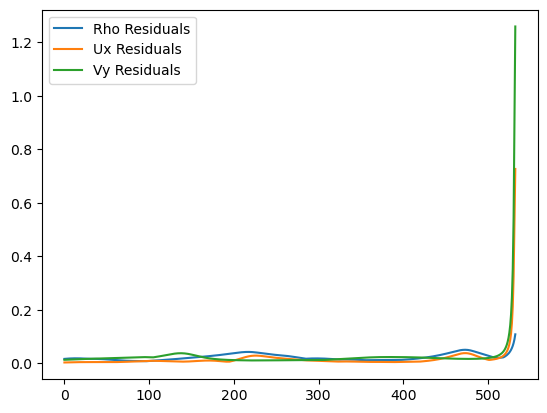

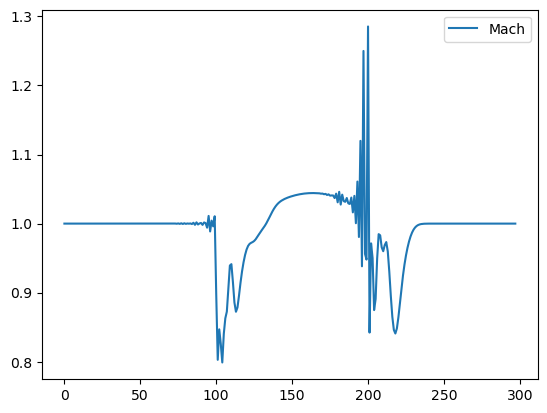

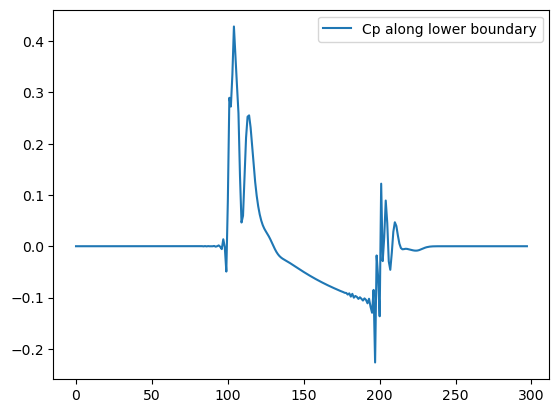

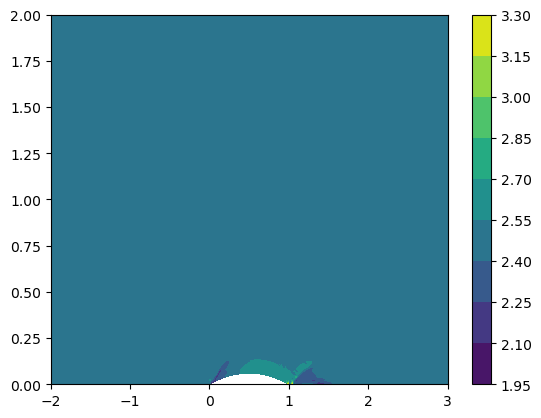

In [16]:
#plt.imshow(u, interpolation='none') dtref = 0.001 and 20000 iters -> 9132.64 + 9904.87 + 17401.22 + 9972.60 seconds
#plt.colorbar()

plt.plot(Residuals_rho, label='Rho Residuals')
plt.plot(Residuals_u, label='Ux Residuals')
plt.plot(Residuals_v, label='Vy Residuals')
plt.legend()
plt.show()

plt.plot(u[0,:], label='Mach')
plt.legend()
plt.show()

plt.plot(Cp, label='Cp along lower boundary')
plt.legend()
plt.show()

plt.contourf(xpoints, ypoints, M)
plt.colorbar() # Add a colorbar to a plot
#plt.axis('equal')
#plt.xlim([-1, 2])
plt.show()